* 次のスライドで公開したもののコードです
  * 
<script async class="docswell-embed" src="https://www.docswell.com/assets/libs/docswell-embed/docswell-embed.min.js" data-src="https://www.docswell.com/slide/ZXW7R5/embed" data-aspect="0.5625"></script><div class="docswell-link"><a href="https://www.docswell.com/s/currypurin/ZXW7R5-2021-12-31-162041">Numerai Tournamentの概要とどう取り組むかの種 by @currypurin</a></div>
* 順に動かすとnumeraiのsuper massive dataが少しわかると思います
* 動かすだけならnumeraiのアカウントは不要です
* submitしたい人は、[numerai](https://numer.ai/tournament)からアカウントを作成し、submitしてください

In [32]:
!pip install numerapi -qq
!pip install numpy-indexed -qq

In [33]:
from pathlib import Path
import pickle
import json

from IPython import embed
import numerapi
from numerapi import NumerAPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import numpy_indexed as npi
import warnings
warnings.simplefilter('ignore')
plt.style.use('fivethirtyeight')

napi = numerapi.NumerAPI(verbosity="info")
current_round = napi.get_current_round()  # 現在のroundを取得
print('current_round', current_round)


def sizeof_fmt(num, suffix='B'):
    """読みやすいように単位をつける"""
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


def get_memory_usage_from_df(df: pd.DataFrame):
    """dataframeのサイズを返す"""
    return sizeof_fmt(df.memory_usage(index=True).sum())     


def get_massive_data(mode: str, round: int):
    """
    mode: training, validation, tournament
    round: ラウンド数
    """
    parquet_path = Path(f'{mode}_data_int8_{current_round}.parquet')
    if not parquet_path.is_file():
        napi.download_dataset(filename=f"numerai_{mode}_data_int8.parquet",
                              dest_path=str(parquet_path),
                              round_num=round)
    df = pd.read_parquet(f'{mode}_data_int8_{current_round}.parquet')
    return df

current_round 296


## データの取得

In [34]:
train = get_massive_data('training', current_round)
valid = get_massive_data('validation', current_round)
test = get_massive_data('tournament', current_round)
# napi.download_dataset('example_validation_predictions.parquet', 'example_validation_predictions.parquet')
napi.download_dataset('features.json', 'features.json')
with open("features.json", "r") as f:
    feature_metadata = json.load(f)
    
print('train:', get_memory_usage_from_df(train), train.shape)
print('valid:', get_memory_usage_from_df(valid), valid.shape)
print('test:', get_memory_usage_from_df(test), test.shape)

2021-12-31 07:32:21,950 INFO numerapi.utils: target file already exists
2021-12-31 07:32:21,951 INFO numerapi.utils: download complete


train: 2.6GiB (2412105, 1073)
valid: 596.0MiB (539658, 1073)
test: 1.6GiB (1412962, 1073)


## 簡単なEDA

In [35]:
train.iloc[:, :5].head()

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz
id,,,,,
n003bba8a98662e4,0001,train,4,2,4
n003bee128c2fcfc,0001,train,2,4,1
n0048ac83aff7194,0001,train,2,1,3
n00691bec80d3e02,0001,train,4,2,2
n00b8720a2fdc4f2,0001,train,4,3,4


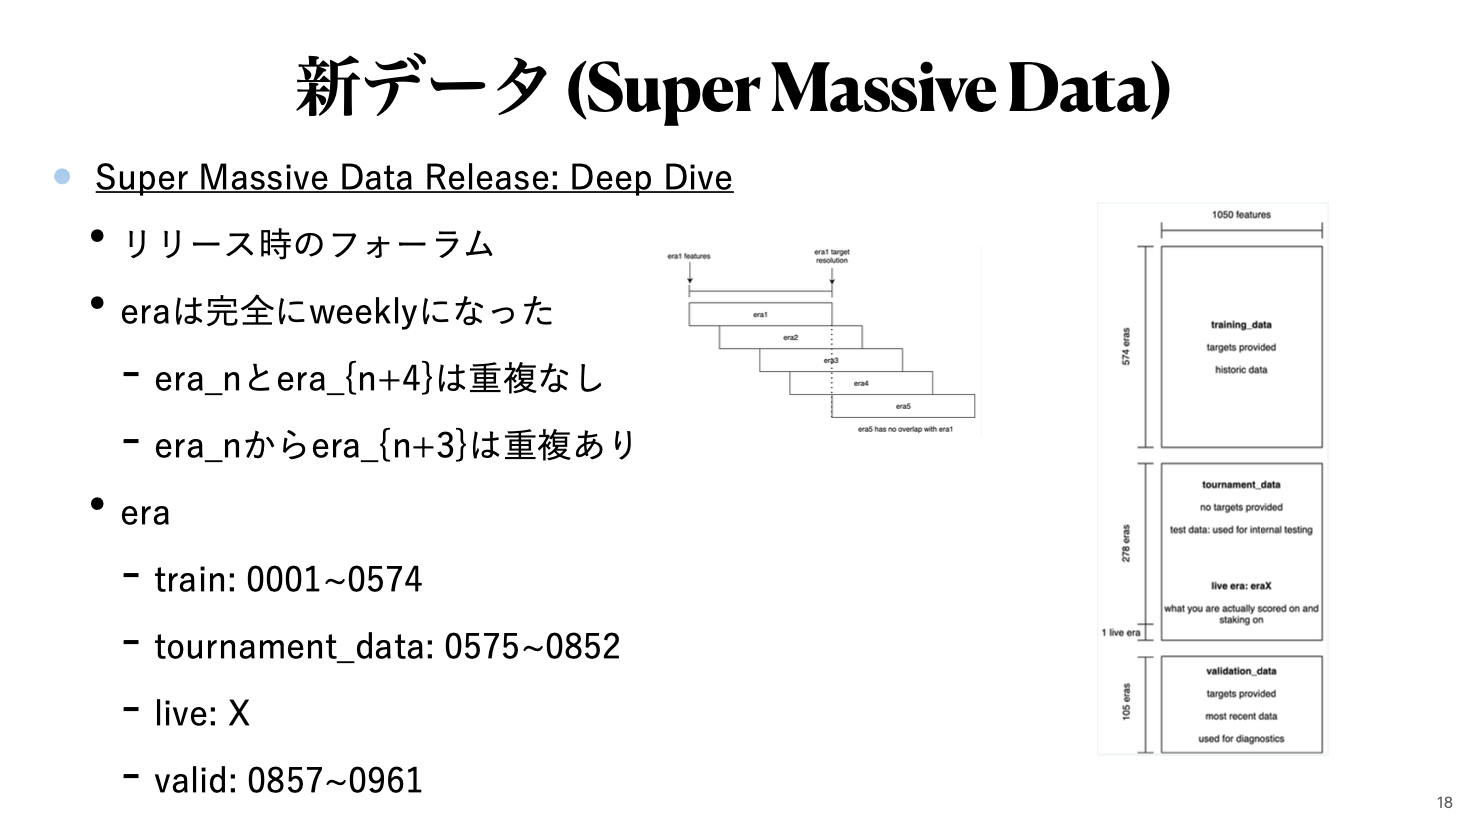

[Super Massive Data Release: Deep Dive \- Data Science \- Numerai Forum](https://forum.numer.ai/t/super-massive-data-release-deep-dive/4053)

In [36]:
display(train['target'].value_counts(normalize=True).sort_index())

0.00    0.050003
0.25    0.199996
0.50    0.499993
0.75    0.200015
1.00    0.049992
Name: target, dtype: float64

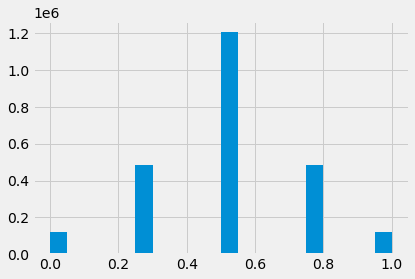

In [37]:
plt.hist(train['target'], bins=20)
plt.show()

## targetの欠損


In [38]:
display(train[train.columns[train.columns.str.contains('target')]].isnull().sum().reset_index().rename(columns={0: 'null_count', 'index': 'col_name'}).sort_values('null_count').reset_index(drop=True))

,col_name,null_count
0,target,0
1,target_nomi_20,0
2,target_ben_20,0
3,target_george_20,0
4,target_alan_20,0
5,target_thomas_20,0
6,target_arthur_20,329
7,target_jerome_20,329
8,target_william_20,329
9,target_janet_20,329


In [39]:
# targetとtarget_nomi_20は全て同じ
np.all(train['target'] == train['target_nomi_20'])

True

In [40]:
# feature_metadataのsetと特徴数
print({key: len(feature_metadata['feature_sets'][key]) for key in feature_metadata['feature_sets'].keys()})

{'legacy': 304, 'small': 38, 'medium': 420}


In [41]:
# このnotebookでは、small: 38特徴を採用する
features = feature_metadata['feature_sets']['small']
len(features)

38

## LihgtGBM

### valid全体の平均でearly stoppingする

In [42]:
class CFG:
    target_col = 'target'


lgb_params = {'objective': 'regression',
              'metric': 'None',
              'first_metric_only': True,
              'boosting_type': 'gbdt',
              "num_leaves": 63,
              "max_depth": 6,
              'learning_rate': 0.5,  # 大きめにとりあえず設定
              'min_data_in_leaf': 100  # このデータだと、min_data_in_leafにより、scoreはかなり変わると思う
              }


def compute_corr_for_lgb(preds, target):
    # validの全体の平均を返すmetric
    preds_rank = pd.Series(preds).rank(pct=True, method="first")
    corr = np.corrcoef(preds_rank, target.get_label())[0, 1]
    return 'corr', corr, True


def single_lgb(train, valid, features, params, feval=None):

    d_train = lgb.Dataset(train[features].values,
                          train[CFG.target_col].values,
                          feature_name=features)
    d_eval = lgb.Dataset(valid[features].values,
                         valid[CFG.target_col].values,
                         feature_name=features)
    evals_result = {}
    model = lgb.train(params,
                      d_train,
                      num_boost_round=10000,
                      valid_sets=[d_train, d_eval],
                      early_stopping_rounds=50,
                      evals_result=evals_result,
                      verbose_eval=30,
                      feval=feval)
    return model, evals_result

In [43]:
model, evals_result = single_lgb(train, valid, features, lgb_params, compute_corr_for_lgb)

Training until validation scores don't improve for 50 rounds.
[30]	training's corr: 0.110184	valid_1's corr: 0.0177275
[60]	training's corr: 0.142054	valid_1's corr: 0.0166129
Early stopping, best iteration is:
[11]	training's corr: 0.0814145	valid_1's corr: 0.0188119


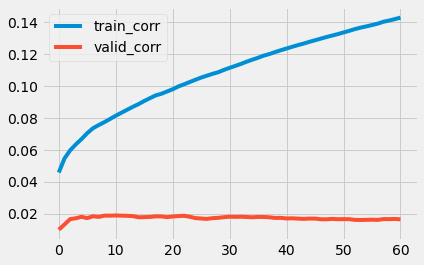

In [44]:
plt.plot(evals_result['training']['corr'], label='train_corr')
plt.plot(evals_result['valid_1']['corr'], label='valid_corr')
plt.legend()
plt.show()

### validのera毎のcorrの平均でearly stoppingする

In [45]:
import numpy_indexed as npi


def get_massive_data(mode: str, round: int):
    """
    mode: training, validation, tournament
    round: ラウンド数
    """
    parquet_path = Path(f'{mode}_data_int8_{current_round}.parquet')
    if not parquet_path.is_file():
        napi.download_dataset(filename=f"numerai_{mode}_data_int8.parquet",
                              dest_path=str(parquet_path),
                              round_num=round)
    df = pd.read_parquet(f'{mode}_data_int8_{current_round}.parquet')
    return df


class MetricCorr:
    def __init__(self, era_group: pd.Series):
        self.group = npi.group_by(era_group.values)

    def corrs(self, preds, target):
        labels = self.group.split(target)
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_list = [np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)]
        return corr_list

    def corr_mean_lgb(self, preds: np.ndarray, data: lgb.Dataset):
        labels = self.group.split(data.get_label())
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_mean = np.mean([np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)])
        return 'corr_mean', corr_mean, True

    def corr_mean_xgb(self, preds: np.ndarray, data: xgb.DMatrix):
        # https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html#customized-metric-function
        labels = self.group.split(data.get_label())
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_mean = np.mean([np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)])
        return 'corr_mean', corr_mean

In [46]:
compute_metric = MetricCorr(valid['era'])
model, evals_result = single_lgb(train, valid, features, lgb_params, compute_metric.corr_mean_lgb)

Training until validation scores don't improve for 50 rounds.
[30]	training's corr_mean: 0.11831	valid_1's corr_mean: 0.0175573
[60]	training's corr_mean: 0.146185	valid_1's corr_mean: 0.0164623
Early stopping, best iteration is:
[11]	training's corr_mean: 0.0909901	valid_1's corr_mean: 0.0186795


## xgboost

In [47]:
def single_lgb(train, valid, features, params, feval=None):

    d_train = lgb.Dataset(train[features].values,
                          train[CFG.target_col].values,
                          feature_name=features)
    d_eval = lgb.Dataset(valid[features].values,
                         valid[CFG.target_col].values,
                         feature_name=features)
    evals_result = {}
    model = lgb.train(params,
                      d_train,
                      num_boost_round=10000,
                      valid_sets=[d_train, d_eval],
                      early_stopping_rounds=50,
                      evals_result=evals_result,
                      verbose_eval=30,
                      feval=feval)
    return model, evals_result

In [48]:
xgb_params = {'objective': 'reg:squarederror',
            'max_depth': 10,
            'eta': 0.1,
            'min_child_weight': 1594,
            'subsample': 0.95,
            'colsample_bytree': 0.8,
            'silent': 1,
            'num_round': 10000,
            'early_stopping_rounds': 20,
            'tree_method' : 'gpu_hist',
            'reg_alpha': 0.001,
            'reg_lambda': 1.0
            }


def single_xgb(train, valid, features, params, feval=None):

    d_train = xgb.DMatrix(train[features], train[CFG.target_col])
    d_eval = xgb.DMatrix(valid[features], valid[CFG.target_col])
    evals_result = {}
    watchlist = [(d_eval, 'eval')]

    early_stopping_rounds = params.pop('early_stopping_rounds')

    model = xgb.train(params,
                       d_train,
                       params['num_round'],
                       evals=watchlist,
                       feval=feval,
                       maximize=True,
                       early_stopping_rounds=early_stopping_rounds,
                       evals_result=evals_result,
                       verbose_eval=10)
    return model, evals_result

In [49]:
compute_metric = MetricCorr(valid['era'])
model, result = single_xgb(train, valid, features, xgb_params, compute_metric.corr_mean_xgb)

[0]	eval-rmse:0.223566	eval-corr_mean:0.012255
Multiple eval metrics have been passed: 'eval-corr_mean' will be used for early stopping.

Will train until eval-corr_mean hasn't improved in 20 rounds.
[10]	eval-rmse:0.223585	eval-corr_mean:0.017472
[20]	eval-rmse:0.22365	eval-corr_mean:0.018973
[30]	eval-rmse:0.223737	eval-corr_mean:0.017705
[40]	eval-rmse:0.223784	eval-corr_mean:0.018691
[50]	eval-rmse:0.223841	eval-corr_mean:0.018676
[60]	eval-rmse:0.223873	eval-corr_mean:0.01925
[70]	eval-rmse:0.223906	eval-corr_mean:0.019562
[80]	eval-rmse:0.223954	eval-corr_mean:0.019205
[90]	eval-rmse:0.223978	eval-corr_mean:0.019909
[100]	eval-rmse:0.224017	eval-corr_mean:0.019651
[110]	eval-rmse:0.22405	eval-corr_mean:0.019797
[120]	eval-rmse:0.224079	eval-corr_mean:0.019994
[130]	eval-rmse:0.224118	eval-corr_mean:0.019676
Stopping. Best iteration:
[114]	eval-rmse:0.224057	eval-corr_mean:0.020066



In [50]:
np.max(result['eval']['rmse'])

0.224128

In [51]:
np.max(result['eval']['corr_mean'])

0.020066

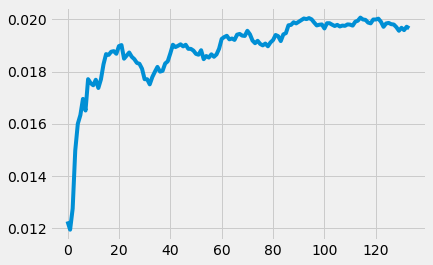

In [52]:
plt.plot(result['eval']['corr_mean'])
plt.show()

## Catboost

In [53]:
!pip install catboost -qq

## GPUを使わずに、Custommetricsを使う

* Custom Metricsを使うとGPUを使えない
  * https://github.com/catboost/catboost/issues/736
* そのためcorr_meanを最大化するために、次の２つの方法がある
  * GPUを使わずに、Custom Metricsを用いて、corr meanでearly stoppingする
  * GPUを使って学習し、後から全itrについてcorr meanを計算しなおす
  * まずは前者の方法をやってみる


In [54]:
class MetricCorrCatboost:
    """https://catboost.ai/en/docs/concepts/python-usages-examples#rmse1"""

    def __init__(self, era_group: pd.Series):
        self.group = npi.group_by(era_group.values)

    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        approx = approxes[0]
        labels = self.group.split(target)
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(approx)]
        corr_mean = np.mean([np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)])

        output_weight = 1  # weight is not used
        return corr_mean, output_weight

In [55]:
from catboost import CatBoost, Pool
import catboost


def single_cat(train, valid, features, params, eval_metric=None):
    train_pool = Pool(train[features], train[CFG.target_col])
    valid_pool = Pool(valid[features], valid[CFG.target_col])

    if eval_metric:
        params['eval_metric'] = eval_metric

    model = CatBoost(params)
    model.fit(train_pool,
             eval_set=[train_pool, valid_pool],
             early_stopping_rounds=20,
             verbose_eval=10)
    return model


cat_params = {'loss_function': 'RMSE',
                'iterations':50,
                'random_seed': 0}

model = single_cat(train, valid, features, cat_params, eval_metric=MetricCorrCatboost(valid['era']))

Learning rate set to 0.5
0:	learn: 0.0464237	test: 0.0464237	test1: 0.0123839	best: 0.0123839 (0)	total: 472ms	remaining: 23.1s
10:	learn: 0.0738115	test: 0.0738115	test1: 0.0178304	best: 0.0182381 (4)	total: 4.85s	remaining: 17.2s
20:	learn: 0.0805874	test: 0.0805874	test1: 0.0194843	best: 0.0195521 (17)	total: 9.17s	remaining: 12.7s
30:	learn: 0.0861885	test: 0.0861885	test1: 0.0201979	best: 0.0201979 (30)	total: 13.5s	remaining: 8.27s
40:	learn: 0.0911902	test: 0.0911902	test1: 0.0202676	best: 0.0204933 (38)	total: 17.8s	remaining: 3.91s
49:	learn: 0.0953973	test: 0.0953973	test1: 0.0199495	best: 0.0208209 (42)	total: 21.7s	remaining: 0us

bestTest = 0.02082088065
bestIteration = 42

Shrink model to first 43 iterations.


In [56]:
model.get_best_iteration()

42

In [57]:
valid_pred = model.predict(Pool(valid[features]))
score = np.mean(compute_metric.corrs(valid_pred, valid[CFG.target_col]))
print(score)  # scoreの確認

0.020820880654985705


### GPUを使う

In [58]:
from catboost import CatBoost
from catboost import Pool


def single_cat(train, valid, features, params, eval_metric=None):
    train_pool = Pool(train[features], train[CFG.target_col])
    valid_pool = Pool(valid[features], valid[CFG.target_col])

    if eval_metric:
        params['eval_metric'] = eval_metric
    model = CatBoost(params)
    model.fit(train_pool,
              eval_set=[valid_pool],
              verbose_eval=10)
    return model


cat_params = {'loss_function': 'RMSE',
                'task_type': 'GPU',
                'iterations':50,
                'random_seed': 0,
                'use_best_model': False}

model = single_cat(train, valid, features, cat_params)

Learning rate set to 0.5
0:	learn: 0.2234874	test: 0.2235556	best: 0.2235556 (0)	total: 9.97ms	remaining: 489ms
10:	learn: 0.2231309	test: 0.2236319	best: 0.2235556 (0)	total: 103ms	remaining: 366ms
20:	learn: 0.2229950	test: 0.2236909	best: 0.2235556 (0)	total: 194ms	remaining: 267ms
30:	learn: 0.2228862	test: 0.2237377	best: 0.2235556 (0)	total: 284ms	remaining: 174ms
40:	learn: 0.2227800	test: 0.2237670	best: 0.2235556 (0)	total: 372ms	remaining: 81.7ms
49:	learn: 0.2226905	test: 0.2238038	best: 0.2235556 (0)	total: 454ms	remaining: 0us
bestTest = 0.2235556473
bestIteration = 0


In [59]:
from tqdm import tqdm

class MetricCorr:
    def __init__(self, era_group: pd.Series):
        self.group = npi.group_by(era_group.values)

    def corrs(self, preds, target):
        labels = self.group.split(target)
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_list = [np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)]
        return corr_list

    def corr_mean_lgb(self, preds: np.ndarray, data: lgb.Dataset):
        labels = self.group.split(data.get_label())
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_mean = np.mean([np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)])
        return 'corr_mean', corr_mean, True

    def corr_mean_xgb(self, preds: np.ndarray, data: xgb.DMatrix):
        # https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html#customized-metric-function
        labels = self.group.split(data.get_label())
        preds_rank = [pd.Series(p).rank(pct=True, method="first").values for p in self.group.split(preds)]
        corr_mean = np.mean([np.corrcoef(preds, rank)[0, 1] for preds, rank in zip(preds_rank, labels)])
        return 'corr_mean', corr_mean

mean_corrs = []
compute_metric = MetricCorr(valid['era'])
valid_pool = Pool(valid[features])

for valid_pred in tqdm(model.staged_predict(valid_pool, ntree_end=50)):
    corrs = compute_metric.corrs(valid_pred, valid[CFG.target_col])
    mean_corrs.append(np.mean(corrs))

50it [00:06,  7.48it/s]


best_itr: 34, best_corr: 0.021228356002154516


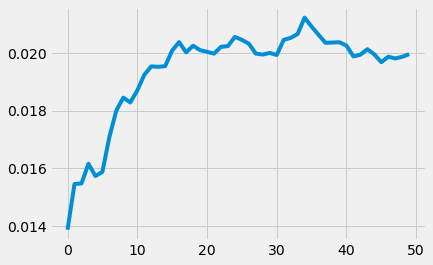

In [60]:
bestIteration = np.argmax(mean_corrs)
print(f'best_itr: {bestIteration}, best_corr: {np.max(mean_corrs)}')
plt.plot(mean_corrs)
plt.show()

In [61]:
valid_pred = model.predict(Pool(valid[features]), ntree_end=bestIteration + 1)
score = np.mean(compute_metric.corrs(valid_pred, valid[CFG.target_col]))
print(score)  # scoreの確認

0.021228356002154516
